<small><i>Updated February 2023 - This notebook was created by [Santi Seguí](https://ssegui.github.io/). </i></small>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\35796\AppData\Local\Temp\ipykernel_9736\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Let's create a Non-Personalised Recommender using MovieLens Dataset
We will work with the well known MovieLens dataset (http://grouplens.org/datasets/movielens/). This dataset was initially constructed to support participants in the Netflix Prize. Today, we can find several versions of this dataset with different amout of data, from 100k samples version to 20m sample version. Although performance on bigger dataset is expected to be better, we will work with the smallest dataset: MovieLens 1M Dataset (ml-1m.zip). Working with this lite version has the benefit of less computational costs

With a unix machine the dataset can be downloaded with the following code:


### We will use the Movielens 1 million dataset. We download it and uncompress the file we need.

In [3]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip 
!unzip ml-1m.zip -d "data/"

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


If you are working with a windows machine, please go to the website and download the ml-1m version and extract it to the subdirectory named "data/ml-1m/"

Once you have downloaded and unzipped the file into a directory, you can create a DataFrame with the following code:

In [6]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt

# Load Data set
u_cols = ['user_id', 'sex', 'age', 'occupation', 'zip_code']
users = pd.read_csv('./data/ml-1m/users.dat', sep='::', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date',]
movies = pd.read_csv('./data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


n_users = data.user_id.nunique()
n_items = data.movie_id.nunique()
print("La BD has "+ str(data.shape[0]) +" ratings")
print("La BD has ", n_users," users")
print("La BD has ", n_items, " movies")
data.head()


Autosaving every 150 seconds


C:\Users\35796\AppData\Local\Temp\ipykernel_9736\3299491286.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv('./data/ml-1m/users.dat', sep='::', names=u_cols)
C:\Users\35796\AppData\Local\Temp\ipykernel_9736\3299491286.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('./data/ml-1m/ratings.dat', sep='::', names=r_cols)
C:\Users\35796\AppData\Local\Temp\ipykernel_9736\3299491286.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as 

La BD has 1000209 ratings
La BD has  6040  users
La BD has  3706  movies


,user_id,title,movie_id,rating,release_date,sex,age
0,1,One Flew Over the Cuckoo's Nest (1975),1193,5,Drama,F,1
1,2,One Flew Over the Cuckoo's Nest (1975),1193,5,Drama,M,56
2,12,One Flew Over the Cuckoo's Nest (1975),1193,4,Drama,M,25
3,15,One Flew Over the Cuckoo's Nest (1975),1193,4,Drama,M,25
4,17,One Flew Over the Cuckoo's Nest (1975),1193,5,Drama,M,50


If you explore the dataset in detail, you will see that it consists of:

1.000.209 ratings from 6040 users of 3706 movies. Ratings are from 1 to 5.
Simple demographic info for the users (age, gender, occupation, zip)

In [7]:
print ("Average interactions per user {:.2f}".format(data.shape[0]/n_users))
print ("Average interactions per item {:.2f}".format(data.shape[0]/n_items))

print ("Sparsity {:.2f} %".format((1- data.shape[0]/(n_items*n_users))*100))


Average interactions per user 165.60
Average interactions per item 269.89
Sparsity 95.53 %


### Ranking by polularity
We compute the item popularity as the number of interaction in each column


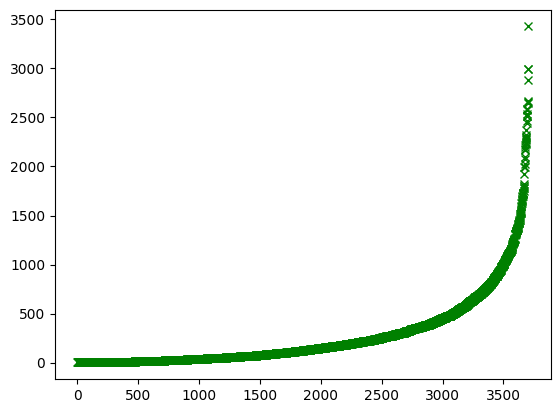

In [8]:
mean_score = data.groupby(['movie_id'])[['rating','movie_id']].agg({'rating':'mean',
                                                              'movie_id':'count'}).rename(columns = {'rating': 'mean_rating','movie_id':'num_ratings'})

item_popularity = mean_score.sort_values(by='num_ratings',ascending=True)['num_ratings'].values

plt.plot(item_popularity,'gx')
plt.show()

In [9]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 269.89
Average per-item interactions for the top 10% popular items 1199.74
Average per-item interactions for the least 10% popular items 2.85
Average per-item interactions for the median 10% popular items 123.66


## We compute the user activity (profile length) as the number of interaction in each row

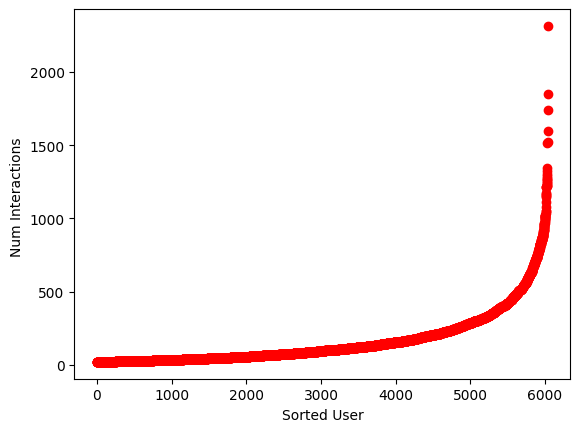

In [10]:
user_activity = data[['user_id','rating']].groupby(['user_id']).count()
user_activity = np.sort(user_activity.rating.values)

plt.plot(user_activity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted User')
plt.show()

## In order to create a Recommender we have to define:
* A splitting of the data
* An evaluation metric
* A function to evaluate for each user

## The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. 
We create two splits:
* Train
* Test

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=7)

## Evaluation metric
We call items in the test set 'relevant'


In [12]:
# These are the relevat items for one user

user_id = 1
relevant_items = test[test.user_id==user_id].movie_id.values
relevant_items

array([2294, 1035,  919, 1907, 2028,  914,  531,  720,  260, 1270, 1207,
       2018, 1028], dtype=int64)

In [13]:
# let's imagin our recommender sytes recommend the following item
recommended_items = np.array([241, 2028, 114, 857, 1823])
recommended_items

array([ 241, 2028,  114,  857, 1823])

In [14]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([False,  True, False, False, False])

## We can use several metrics. 
These are some of the most classical ones:
* Precision
* Recall
* Average Precison


## Precision: how many of the recommended items are relevant

In [15]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

## Recall: how many of the relevant items I was able to recommend

In [16]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

## Average Precision
this one is more commonly used

In [17]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

## Now that we have the data, we can build our first recommender. We need two things:
* a'fit' function to train our model
* a 'recommend' function that uses our model to recommend

## Let's start with a random recommender


In [18]:
class RandomRecommender():

    def fit(self, train):
        
        self.items = train.title.unique()
    
    def recommend(self, user_id, at=5):
    
        recommended_items = np.random.choice(self.items, at)
        return recommended_items

In [19]:
randomRecommender = RandomRecommender()
randomRecommender.fit(train)

for user_id in range(10):
    print(randomRecommender.recommend(user_id, at=5))

['Billy Madison (1995)' 'Brenda Starr (1989)'
 'Operation Dumbo Drop (1995)' 'Prom Night (1980)'
 'To Catch a Thief (1955)']
["Billy's Holiday (1995)" 'Cry, the Beloved Country (1995)'
 'Invasion of the Body Snatchers (1956)' 'Buffalo 66 (1998)'
 'Skulls, The (2000)']
['Misérables, Les (1995)' 'Fallen (1998)' 'Hamlet (1996)'
 'Police Academy (1984)' "She's Gotta Have It (1986)"]
['Nothing to Lose (1994)' 'Touch of Evil (1958)' "Doug's 1st Movie (1999)"
 'One Night Stand (1997)' 'Shattered Image (1998)']
["Kid in King Arthur's Court, A (1995)" 'Ride with the Devil (1999)'
 'My Favorite Season (1993)' "She's Gotta Have It (1986)"
 'Runaway Train (1985)']
["Mummy's Tomb, The (1942)" 'Major Payne (1994)'
 'Godzilla 2000 (Gojira ni-sen mireniamu) (1999)' 'Bio-Dome (1996)'
 '8 Heads in a Duffel Bag (1997)']
['Secret Agent, The (1996)' 'Two Thousand Maniacs! (1964)'
 'Once Upon a Time in America (1984)'
 'Mr. Death: The Rise and Fall of Fred A. Leuchter Jr. (1999)'
 'Iron Eagle IV (1995)']
['

## Put all together in an evaluation function and let's test it!


In [20]:
# We pass as paramether the recommender class

def evaluate_algorithm(test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    num_eval = 0

    for user_id in test.user_id.unique():

        relevant_items = test[test.user_id==user_id].title.values
    
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 

In [21]:
evaluate_algorithm(test, randomRecommender)

Recommender results are: Precision = 0.0088, Recall = 0.0014, MAP = 0.0042


### Everything works but for sure it can be improved..

## Let's build a TOP POPULAR RECOMMENDER

We recommend to all users the most popular items, that is those with the highest number of interactions
In this case our model is the item popularity


In [40]:
class TopPopRecommender(object):

    def fit(self, train):
        item_popularity = train[['title','rating']].groupby(by='title').count()
        self.popular_items = item_popularity.sort_values(by= 'rating', ascending=False).index
    
    
    def recommend(self, user_id, at=5):
        return self.popular_items[0:at]
    

In [41]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(train)

In [42]:
for user_id in range(10):
    print(topPopRecommender.recommend(user_id, at=5))

Index(['American Beauty (1999)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)'],
      dtype='object', name='title')
Index(['American Beauty (1999)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)'],
      dtype='object', name='title')
Index(['American Beauty (1999)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)'],
      dtype='object', name='title')
Index(['American Beauty (1999)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: E

In [25]:
evaluate_algorithm(test, topPopRecommender, at=5)

Recommender results are: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


## What if we only recommend unseen items?

In [52]:
class TopPopRecommender():

    def fit(self, train):
        self.train = train 
        item_popularity = train[['title','rating']].groupby(by='title').count()
        self.popular_items = item_popularity.sort_values(by= 'rating', ascending=False).index
        
    def recommend(self, user_id, at=5, remove_seen = True):
        if remove_seen == True:
            seen_movies = self.train[self.train.user_id == user_id].title.values
            unseen_movies_mask = np.in1d(self.popular_items, seen_movies, invert=True)
            unseen_items = self.popular_items[unseen_movies_mask]
            return unseen_items[0:at]
        else:
            return self.popular_items[0:at]


In [53]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(train)

for user_id in range(5):
    print(topPopRecommender_removeSeen.recommend(user_id, at=5))

Index(['American Beauty (1999)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)'],
      dtype='object', name='title')
Index(['American Beauty (1999)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)'],
      dtype='object', name='title')
Index(['Star Wars: Episode IV - A New Hope (1977)', 'Matrix, The (1999)',
       'Back to the Future (1985)', 'Men in Black (1997)', 'Fargo (1996)'],
      dtype='object', name='title')
Index(['Star Wars: Episode IV - A New Hope (1977)',
       'Saving Private Ryan (1998)', 'Terminator 2: Judgment Day (1991)',
       'Matrix, The (1999)', 'Fargo (1996)'],
      dtype='object', name='title')
Index(['American Beauty (1999)', 'Jurassic Park (199

In [54]:
evaluate_algorithm(test, topPopRecommender_removeSeen)

Recommender results are: Precision = 0.2088, Recall = 0.0410, MAP = 0.1499


##  Let's build a HIGHEST RATED RECOMMENDER
We recommend to all users the items with the highest mean rating.
In this case our model is the item mean rating

In [29]:
globalAverage = train.rating.mean()
print("The global average is {:.2f}".format(globalAverage))

The global average is 3.58


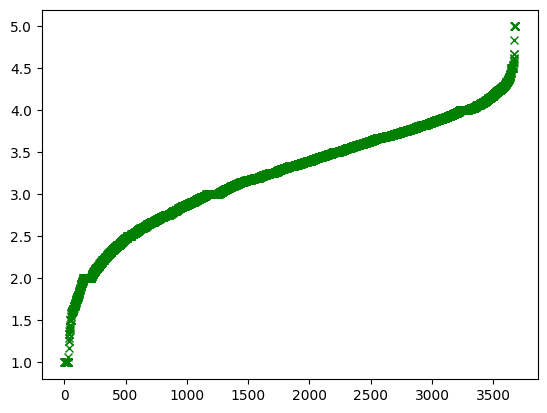

In [30]:
mean_item_rating = train[['movie_id','rating']].groupby(by ='movie_id').mean().rating.values
plt.plot(np.sort(mean_item_rating),'gx')

In [56]:
train[['title','rating']].groupby(by='title').mean().sort_values(by= 'rating', ascending=False)

,rating
title,
Smashing Time (1967),5.0
Lured (1947),5.0
Bittersweet Motel (2000),5.0
Schlafes Bruder (Brother of Sleep) (1995),5.0
Song of Freedom (1936),5.0
...,...
"McCullochs, The (1975)",1.0
Santa with Muscles (1996),1.0
"Silence of the Palace, The (Saimt el Qusur) (1994)",1.0


In [57]:
class HighestRatedRecommender():

     def fit(self, train):
        self.train = train 
        item_popularity = train[['title','rating']].groupby(by='title').mean()
        self.popular_items = item_popularity.sort_values(by= 'rating', ascending=False).index
        
     def recommend(self, user_id, at=5, remove_seen = True):
        if remove_seen == True:
            seen_movies = self.train[self.train.user_id == user_id].title.values
            unseen_movies_mask = np.in1d(self.popular_items, seen_movies, invert=True)
            unseen_items = self.popular_items[unseen_movies_mask]
            return unseen_items[0:at]
        else:
            return self.popular_items[0:at]

In [58]:
highestScoreRecommender_removeSeen = HighestRatedRecommender()
highestScoreRecommender_removeSeen.fit(train)

for user_id in range(5):
    print(highestScoreRecommender_removeSeen.recommend(user_id, at=5))
    
evaluate_algorithm(test, highestScoreRecommender_removeSeen)

Index(['Smashing Time (1967)', 'Lured (1947)', 'Bittersweet Motel (2000)',
       'Schlafes Bruder (Brother of Sleep) (1995)', 'Song of Freedom (1936)'],
      dtype='object', name='title')
Index(['Smashing Time (1967)', 'Lured (1947)', 'Bittersweet Motel (2000)',
       'Schlafes Bruder (Brother of Sleep) (1995)', 'Song of Freedom (1936)'],
      dtype='object', name='title')
Index(['Smashing Time (1967)', 'Lured (1947)', 'Bittersweet Motel (2000)',
       'Schlafes Bruder (Brother of Sleep) (1995)', 'Song of Freedom (1936)'],
      dtype='object', name='title')
Index(['Smashing Time (1967)', 'Lured (1947)', 'Bittersweet Motel (2000)',
       'Schlafes Bruder (Brother of Sleep) (1995)', 'Song of Freedom (1936)'],
      dtype='object', name='title')
Index(['Smashing Time (1967)', 'Lured (1947)', 'Bittersweet Motel (2000)',
       'Schlafes Bruder (Brother of Sleep) (1995)', 'Song of Freedom (1936)'],
      dtype='object', name='title')
Recommender results are: Precision = 0.0000, Recal

## Does it work? Any idea to improve it?
* HINT 1: we should penalize those items that has been rated by only few users
* HINT 2: Each user has different mean rating.. perhaps, we should remove user_bias

In [65]:
# big number of k very concernative 
k=10
df = train.groupby(['title'])[['title','rating']].agg({'rating': 'mean', 'title' : 'count'}).rename(columns = {'rating': 'mean_rating', 'title' : 'count'})
df = df['mean_rating']*df['count'] + train.rating.mean()*k/(df['count']+k)
df.sort_values()

title
Neon Bible, The (1995)                                          4.256165
Little Indian, Big City (Un indien dans la ville) (1994)        4.256165
Nueba Yol (1995)                                                4.256165
White Boys (1999)                                               4.256165
Mutters Courage (1995)                                          4.256165
                                                                ...     
Saving Private Ryan (1998)                                   9243.016729
Star Wars: Episode VI - Return of the Jedi (1983)            9265.015512
Star Wars: Episode IV - A New Hope (1977)                   10457.015151
Star Wars: Episode V - The Empire Strikes Back (1980)       10459.014661
American Beauty (1999)                                      12031.012778
Length: 3680, dtype: float64

In [30]:
## YOUR IMPROVED MODEL HERE
class HighestRatedRecommender():

     def fit(self, train, k=10):
        self.train = train 
        item_popularity = train[['title','rating']].groupby(by='title').mean()
        self.popular_items = item_popularity.sort_values(by= 'rating', ascending=False).index
        
     def recommend(self, user_id, at=5, remove_seen = True):
        if remove_seen == True:
            seen_movies = self.train[self.train.user_id == user_id].title.values
            unseen_movies_mask = np.in1d(self.popular_items, seen_movies, invert=True)
            unseen_items = self.popular_items[unseen_movies_mask]
            return unseen_items[0:at]
        else:
            return self.popular_items[0:at]

## Let's change the meaning of relevant!
A relevant item should be something with high score

In [31]:
# We pass as paramether the recommender class

def evaluate_algorithm_top(test, recommender_object, at=5, thr_relevant = 4):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in test.user_id.unique():

        relevant_items = test[(test.user_id==user_id )&( test.rating>=thr_relevant)].title.values
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 

In [32]:
## EVALUTE YOUR MODELS WITH THIS NEW STRATEGY

## Conclusions
 * Why is Highest score is performing worse than TopPop even if we are taking into account more information about the interaction?


Sometimes ratings are not really more informative than interactions. The community has been moving away from explicit ratings for a decade now, preferring implicit interactions that are easier to collect and more reliable.
Generally speaking, "more information" is not necessarily better if noisy or hard to model.